In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [38]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    # it will randomly shuffle and load them
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
classes_names= dataset.class_names
classes_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
68*32

2176

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 1 0 2 1 0 1 0 0 1 1 0 2 1 2 1 0 1 1 1 1 1 0 2 0 0 0]


In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[175. 156. 152.]
  [144. 125. 121.]
  [165. 146. 142.]
  ...
  [165. 145. 146.]
  [165. 145. 146.]
  [188. 168. 169.]]

 [[177. 158. 154.]
  [151. 132. 128.]
  [164. 145. 141.]
  ...
  [167. 147. 148.]
  [177. 157. 158.]
  [181. 161. 162.]]

 [[162. 143. 139.]
  [146. 127. 123.]
  [159. 140. 136.]
  ...
  [168. 148. 149.]
  [173. 153. 154.]
  [167. 147. 148.]]

 ...

 [[137. 107. 105.]
  [137. 107. 105.]
  [136. 106. 104.]
  ...
  [110.  82.  81.]
  [172. 144. 143.]
  [137. 109. 108.]]

 [[123.  93.  91.]
  [144. 114. 112.]
  [ 96.  66.  64.]
  ...
  [107.  79.  78.]
  [134. 106. 105.]
  [122.  94.  93.]]

 [[143. 113. 111.]
  [131. 101.  99.]
  [128.  98.  96.]
  ...
  [147. 119. 118.]
  [117.  89.  88.]
  [135. 107. 106.]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


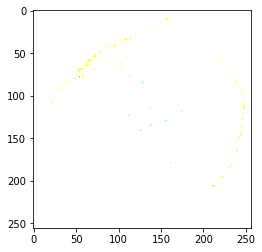

In [12]:

for image_batch, label_batch in dataset.take(1):
    # values are in tensor so we should convert into numpy
    plt.imshow(image_batch[1].numpy())
    
# here it in float so we need convert all this points in int

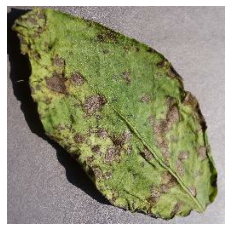

In [13]:



for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.axis("off")

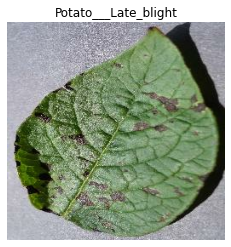

In [14]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.title(classes_names[label_batch[0]])
    plt.axis("off")

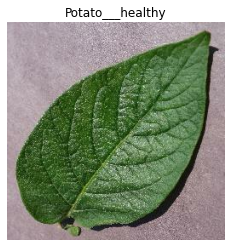

In [15]:
for image_batch, label_batch in dataset.take(1):
    for i  in range(12):
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes_names[label_batch[i]])
        plt.axis("off")

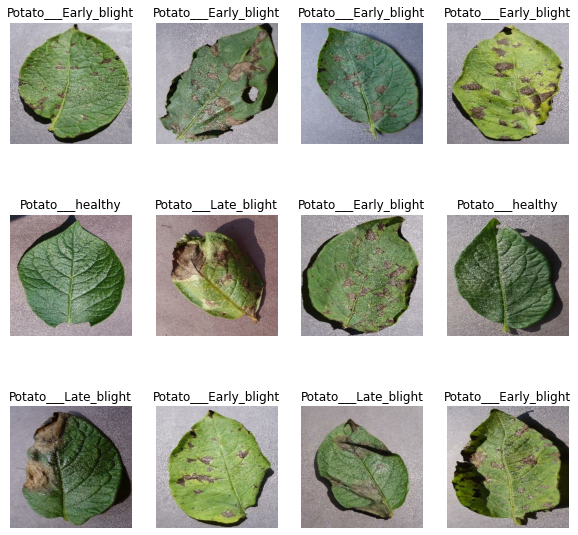

In [16]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i  in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes_names[label_batch[i]])
        plt.axis("off")

In [17]:
len(dataset)

68

 80% ==> training 
 
 
 20% ===> 10% validation set ,10% test 

In [18]:
train_size= 0.8
len(dataset)*train_size

54.400000000000006

In [19]:
#taking 1st 54 data sets for our training the model
train_ds=dataset.take(54)
len(train_ds)

54

In [20]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
test_ds =dataset.skip(54)
len(test_ds)
# means we are skiping 1st  54 data sets samples and taking from  remaining part

14

In [22]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [23]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [24]:
test_ds=test_ds.skip(6)
len(test_ds)

8

Same thing that we are going to implement throught the function in python

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:


len(train_ds)


54

In [28]:
len(val_ds)

6

In [29]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# prefetch if your using gpu and cpu  if gpu  busy in training then prefetch  we load the set batch from your desk  that will improve your performance 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it


In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [34]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
]) 

# Applying Data Augmentation to Train Dataset

In [43]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # we are faltten in the array
    layers.Flatten(),
# one hidden layer layer with 64 neurons
    layers.Dense(64, activation='relu'),
    # one output layer n_classes is 3 outputs for our model
    # softmax is function it will normilize the probablity of classes
    layers.Dense(n_classes, activation='softmax'),
])

In [40]:
model.build(input_shape=input_shape)

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 253s 4s/step - loss: 0.9334 - accuracy: 0.4815 - val_loss: 0.8590 - val_accuracy: 0.6823
Epoch 2/10
54/54 [==============================] - 229s 4s/step - loss: 0.7281 - accuracy: 0.6713 - val_loss: 0.5061 - val_accuracy: 0.8073
Epoch 3/10
54/54 [==============================] - 221s 4s/step - loss: 0.4761 - accuracy: 0.8073 - val_loss: 0.6564 - val_accuracy: 0.7552
Epoch 4/10
54/54 [==============================] - 221s 4s/step - loss: 0.3756 - accuracy: 0.8507 - val_loss: 0.2871 - val_accuracy: 0.8594
Epoch 5/10
54/54 [==============================] - 225s 4s/step - loss: 0.2569 - accuracy: 0.9022 - val_loss: 0.1318 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 218s 4s/step - loss: 0.2276 - accuracy: 0.9062 - val_loss: 0.1135 - val_accuracy: 0.9635
Epoch 7/10
54/54 [==============================] - 170s 3s/step - loss: 0.1941 - accuracy: 0.9265 - val_loss: 0.1330 - val_accuracy: 0.9427
Epoch 8/10
54

In [ ]:
scores = model.evaluate(test_ds)

In [49]:
#### You can see above that we  are geting nearly to  100.00% accuracy  as we increase the no.of epochs for our test dataset. This is considered to be a pretty good accuracy

In [50]:
scores

NameError: name 'scores' is not defined

Scores is just a list containing loss and accuracy value

# Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:

history.params

In [ ]:
history.history.keys()

In [ ]:
### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference 

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Now run inference on few sample images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


## Saving the Model
We append the model to the list of models as a new version

In [51]:
model_version=1
model.save(f"./{model_version}")

INFO:tensorflow:Assets written to: ./1\assets


INFO:tensorflow:Assets written to: ./1\assets
